In [1]:
#Import Library
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

###Mounting Dataset from GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#read zip file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dogSkinDisease/dogSkinDisease.zip', 'r')

#unzip the folder, extract its contents into the /tmp folder
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
#now return the list of the content in that training_set folder
os.listdir('/tmp/dogSkinDisease')

#number of images of each classes in the training_set folder
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/train/flea_allergy'))} train set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/train/hotspot'))} train set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/train/mange'))} train set images of mange.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/train/ringworm'))} train set images of ringworm.")
print()

#now return the list of the content in that validation_set folder
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/validation/flea_allergy'))} val set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/validation/hotspot'))} val set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/validation/mange'))} val set images of mange.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/validation/ringworm'))} val set images of ringworm.")
print()

#now return the list of the content in that testing_set folder
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/testing/flea_allergy'))} test set images of flea allergy.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/testing/hotspot'))} test set images of hotspot.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/testing/mange'))} test set images of mange.")
print(f"There are {len(os.listdir('/tmp/dogSkinDisease/testing/ringworm'))} test set images of ringworm.")

There are 76 train set images of flea allergy.
There are 96 train set images of hotspot.
There are 63 train set images of mange.
There are 138 train set images of ringworm.

There are 20 val set images of flea allergy.
There are 20 val set images of hotspot.
There are 20 val set images of mange.
There are 20 val set images of ringworm.

There are 20 test set images of flea allergy.
There are 20 test set images of hotspot.
There are 20 test set images of mange.
There are 23 test set images of ringworm.


###Train Val Generator

In [5]:
TRAINING_DIR = "/tmp/dogSkinDisease/train"
VALIDATION_DIR = "/tmp/dogSkinDisease/validation"
TESTING_DIR = "/tmp/dogSkinDisease/testing"

TRAINING_FLEA_DIR = "/tmp/dogSkinDisease/train/flea_allergy"
VALIDATION_FLEA_DIR = "/tmp/dogSkinDisease/validation/flea_allergy"
TEST_FLEA_DIR = "/tmp/dogSkinDisease/testing/flea_allergy"

TRAINING_HOTSPOT_DIR = "/tmp/dogSkinDisease/train/hotspot"
VALIDATION_HOTSPOT_DIR = "/tmp/dogSkinDisease/validation/hotspot"
TESTING_HOTSPOT_DIR = "/tmp/dogSkinDisease/testing/hotspot"

TRAINING_MANGE_DIR = "/tmp/dogSkinDisease/train/mange"
VALIDATION_MANGE_DIR = "/tmp/dogSkinDisease/validation/mange"
TESTING_MANGE_DIR = "/tmp/dogSkinDisease/testing/mange"

TRAINING_RINGWORM_DIR = "/tmp/dogSkinDisease/train/ringworm"
VALIDATION_RINGWORM_DIR = "/tmp/dogSkinDisease/validation/ringworm"
TESTING_RINGWORM_DIR = "/tmp/dogSkinDisease/testing/ringworm"

In [6]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                     fill_mode='nearest',
                                     #rotation_range=40,
                                     #width_shift_range=0.2,
                                     #height_shift_range=0.2,
                                     #shear_range=0.2,
                                     #zoom_range=0.2,
                                     #horizontal_flip=True,
                                     )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [7]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 373 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


###Show Sample Images

In [8]:
#create function to show image examples
def show_image_samples(gen):
  train_dict = train_generator.class_indices
  classes = list(train_dict.keys())
  images, labels = next(gen) #get a sample batch from generator
  plt.figure(figsize=(20,20))
  length = len(labels)
  if length < 10:
    r = length
  else:
    r = 10
  for i in range(r):
    plt.subplot(5, 5, i+1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='black', fontsize=18)
    plt.axis('off')
  plt.show()



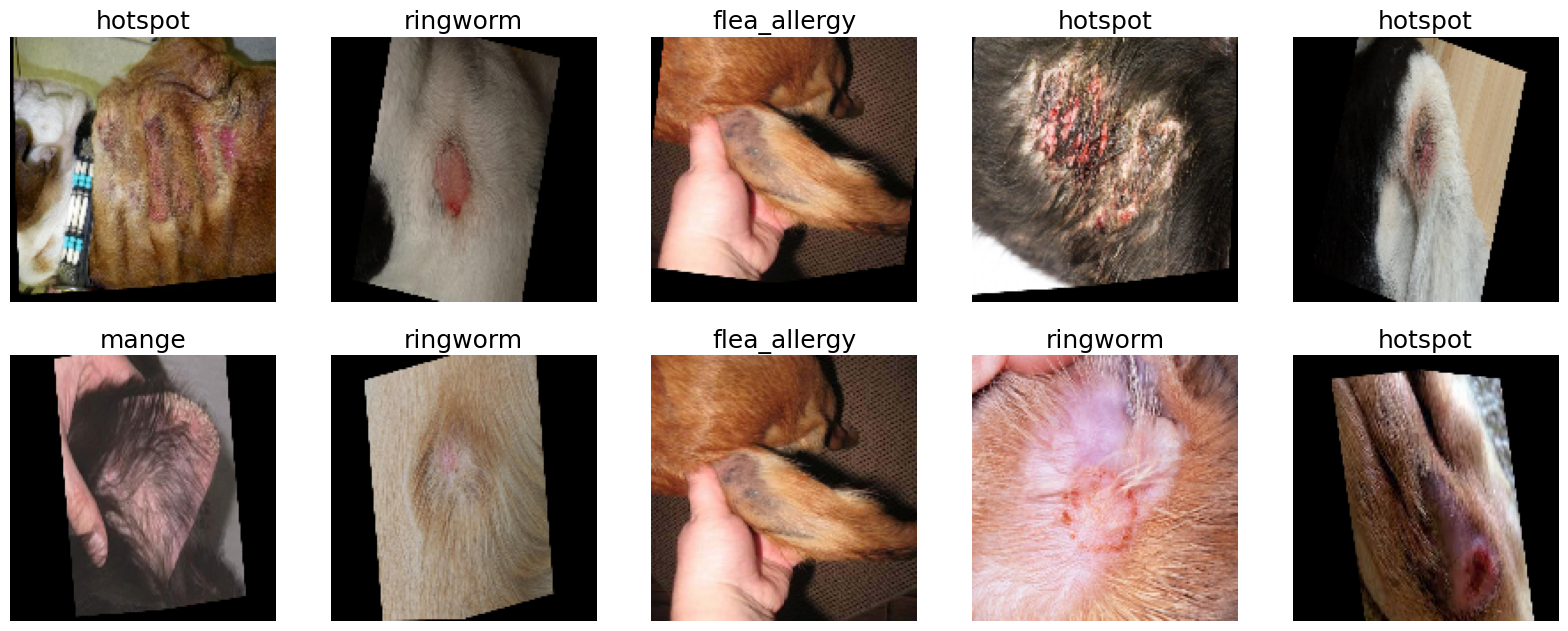

In [9]:
show_image_samples(train_generator)

###Modelling CNN Sederhana

In [10]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Dense(16, activation='relu'),
      #tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')                           
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

  return model

In [11]:
model = create_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 8)        0         
 )                                                               
                                                                 
 dense (Dense)               (None, 74, 74, 16)        144       
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                2803744   
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                        

In [13]:
# Mendefenisikan fungsi Callback
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    min_delta=0.00001,
    verbose=1,
)

# Model Checkpoint
checkpoint_path = 'model_checkpoints/SkinDisease.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weight_only=True,
    verbose=1
)


In [14]:
history = model.fit(train_generator,
            epochs=50,
            validation_data=validation_generator,
            verbose = 1,
            callbacks = [early_stopping, checkpoint])

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 2.0826 - accuracy: 0.2788
Epoch 1: val_loss improved from inf to 1.36167, saving model to model_checkpoints/SkinDisease.h5
24/24 [==============================] - 16s 172ms/step - loss: 2.0826 - accuracy: 0.2788 - val_loss: 1.3617 - val_accuracy: 0.3375
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.2927 - accuracy: 0.3861
Epoch 2: val_loss did not improve from 1.36167
24/24 [==============================] - 6s 238ms/step - loss: 1.2927 - accuracy: 0.3861 - val_loss: 1.3815 - val_accuracy: 0.2875
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 1.1242 - accuracy: 0.4906
Epoch 3: val_loss improved from 1.36167 to 1.09159, saving model to model_checkpoints/SkinDisease.h5
24/24 [==============================] - 4s 159ms/step - loss: 1.1242 - accuracy: 0.4906 - val_loss: 1.0916 - val_accuracy: 0.5250
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 0.9791 - ac

###Plot dan Evaluasi

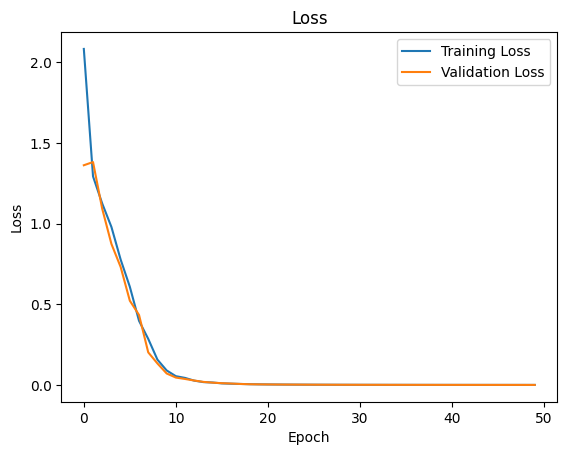

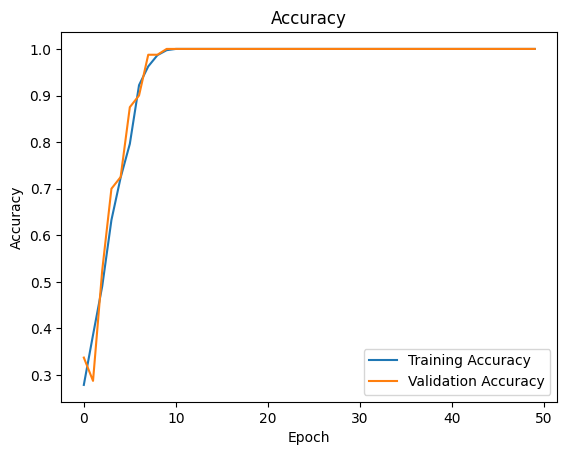

In [15]:
# Obtain training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Draw loss plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()
print()

# Draw accuracy plot
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [16]:
TEST_DIR = "/tmp/dogSkinDisease/testing"
test_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

# pass in the appropriate arguments to the flow_from_directory method
test_set_2 = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

Found 83 images belonging to 4 classes.


In [17]:
Y_pred_2 = model.predict(test_set_2)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

6/6 [==============================] - 1s 117ms/step


In [18]:
print(classification_report(test_set_2.classes, y_pred_2))

              precision    recall  f1-score   support

           0       0.20      0.20      0.20        20
           1       0.25      0.25      0.25        20
           2       0.25      0.25      0.25        20
           3       0.13      0.13      0.13        23

    accuracy                           0.20        83
   macro avg       0.21      0.21      0.21        83
weighted avg       0.20      0.20      0.20        83



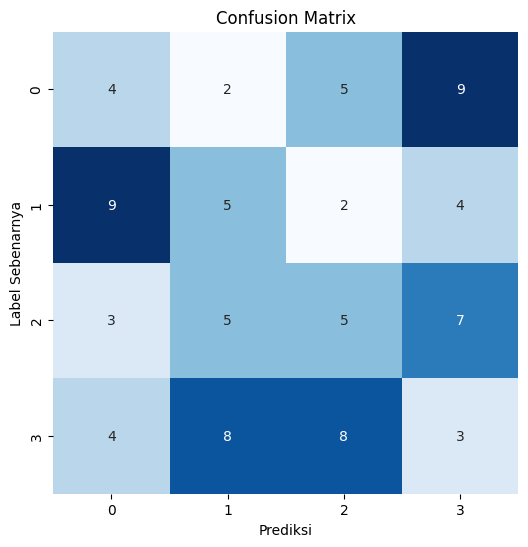

In [19]:
# Misalkan test_set_2.classes adalah label yang sebenarnya dan y_pred_2 adalah label prediksi
y_true = test_set_2.classes  # Label yang sebenarnya
y_pred = y_pred_2  # Label prediksi

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix dalam bentuk heatmap
class_names = ['0', '1', '2', '3']  # Nama kelas (sesuaikan dengan kelas Anda)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

###Save Model h5

In [20]:
#Save model to h5 format

model.save("SkinDisease.h5")

###Predict New Images


In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1.0/225.)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['flea_allergy', 'hotspot', 'mange', 'ringworm']
  df['Animal'] = prod
  df = df[['Animal', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'flea_allergy'
  elif predict_label == 1:
      predict_product = 'hotspot'
  elif predict_label == 2:
      predict_product = 'mange'
  else:
      predict_product = 'ringworm'

  return predict_product, df

Saving luka.png to luka.png
1/1 [==============================] - 0s 21ms/step




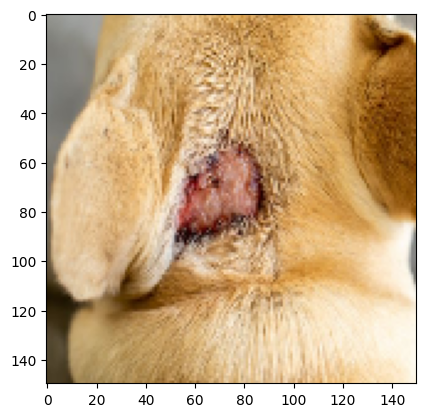


The image is detected as ringworm


         Animal  Probability
0  flea_allergy     0.000029
1       hotspot     0.084000
2         mange     0.000129
3      ringworm     0.915842




In [ ]:
from keras.preprocessing import image
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.preprocessing.image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')